In [1]:
# Package imports
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import t6utils as t6

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

%load_ext autoreload
%autoreload 2

## A. Mini-Batch (Stochastic) Gradient Descent Optimiser ##

Gradient descent is a simple optimisation algorithm where a gradient step is taken with respect to all sample of the training set. It is sometimes referred to as **Batch Gradient Descent** (BGD or simply GD). This is the method we've been using until now.

$$W^{[k]} = W^{[k]} - \lambda \text{ } \frac{\partial \mathcal{L}}{\partial W^{[k]}} = W^{[k]} - \lambda \text{ } dW^{[k]} \tag{1}$$
$$b^{[k]} = b^{[k]} - \lambda \text{ } \frac{\partial \mathcal{L}}{\partial b^{[k]}} = b^{[k]} - \lambda \text{ } db^{[k]}\tag{2}$$


In [2]:
# Update model parameters
def gd_update_params(params, grads, learning_rate=0.8):
    """
    Updates parameters using gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    learning_rate -- learning rate of the gradient descent (hyperparameter)

    Returns:
    params -- dictionary containing updated parameters
    """

    K = len(params) >> 1
    for k in range(1, K + 1):
        params[f"W{k}"] = params[f"W{k}"]-learning_rate*grads[f"dW{k}"]
        params[f"b{k}"] = params[f"b{k}"]-learning_rate*grads[f"db{k}"]
    
    return params

In [3]:
# testing
params, grads = t6.update_params_test()
params = gd_update_params(params, grads, 0.1)
print("W1.T = {}".format(params['W1'].T))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))

W1.T = [[-0.397  1.518  0.582  1.001]
 [ 0.778 -0.334  0.35  -1.558]
 [ 1.472  0.721 -0.231 -0.433]]
b1 = [[-0.071 -0.686  0.24 ]]
W2.T = [[-0.149  2.727  0.619]]
b2 = [[0.748]]


Applying gradient update for each sample in the training set defines a variant of the batch gradient descent called **Stochastic Gradient Descent** (SGD). This is equivalent to a mini-batch gradient descent where each mini-batch contains a single example. The update rule is the same for both SGD and BGD. 

**Mini-Batch Gradient Descent Optimiser**

In practice, we use a trade-off method called mini-batch gradient descent where parameters are updated from the gradients computed on a mini-batch of training examples e.g. 64.  

For each epoch (full batch of examples), mini-batches are constructed by partitioning the shuffled training set. 

Note that we often choose powers of two for the mini-batch size (e.g. 64, 128, 256).


In [4]:
# Shuffle and partition a training set into mini-batches
def stochastic_mini_batches(X, Y, mini_batch_sz=128, seed=2019):
    """
    Creates a list of random mini-batches
    
    Arguments:
    X -- training set a numpy array of shape (n, n_x)
    Y -- training ground truth vector of size (n, n_y)
    mini_batch_sz -- size of the mini-batches, integer
    seed -- random seed for reproducibility
    
    Returns:
    mini_batches -- list of mini-batches [(X_mini_batch, Y_mini_batch), ..., (X_mini_batch, Y_mini_batch)]
    """
    
    np.random.seed(seed)            
    n = X.shape[0]
    mini_batches = []
        
    # Step 1: random permutation of (X, Y)
    permutation = list(np.random.permutation(n))
    X_perm = X[permutation,:]
    Y_perm = Y[permutation,:]


    # Step 2: Partition
    count = int(math.floor(n / mini_batch_sz))
    for i in range(count):
        X_mini_batch = X_perm[i*mini_batch_sz: (i+1)*mini_batch_sz,:]
        Y_mini_batch = Y_perm[i*mini_batch_sz: (i+1)*mini_batch_sz,:]
        mini_batch = (X_mini_batch,Y_mini_batch)
        mini_batches.append(mini_batch)
    
    if n % mini_batch_sz != 0:
        X_mini_batch = X_perm[mini_batch_sz*count :,:]
        Y_mini_batch = Y_perm[mini_batch_sz*count :,:]
        mini_batch = (X_mini_batch,Y_mini_batch)
        mini_batches.append(mini_batch)

    return mini_batches

In [5]:
# testing
X, Y, mini_batch_sz = t6.stochastic_mini_batch_test()
mini_batches = stochastic_mini_batches(X, Y, mini_batch_sz)

print("training set size = {}".format(X.shape[0]))
print("mini-batch size = {}".format(mini_batch_sz))
print("number of mini-batches = {}".format(len(mini_batches)))

import functools
print("number of examples in all mini-batches = {}".format(functools.reduce(lambda x, y : y[0].shape[0] + x , mini_batches, 0)))
print("number of examples in last mini-batch = {}".format(mini_batches[-1][0].shape[0]))

training set size = 132
mini-batch size = 64
number of mini-batches = 3
number of examples in all mini-batches = 132
number of examples in last mini-batch = 4


In [6]:
# Initialise momentum parameters
def initialise_velocity(params):
    """
    Initialises the optimiser velocity
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    
    Returns:
    v -- dictionary containing current velocity
        dW1 -- zero matrix of shape W1
        db1 -- zero matrix of shape b1
        ...
        dWK -- zero matrix of shape WK
        dbK -- zero matrix of shape WK
    """
    
    K = len(params) >> 1
    v = {}
    
    # Initialize velocity
    for k in range(1, K + 1):
        v['dW{}'.format(k)] = np.zeros_like(params[f'W{k}'])
        v['db{}'.format(k)] = np.zeros_like(params[f'b{k}'])
        
    return v

In [7]:
# testing
params = t6.initialise_velocity_test()
v = initialise_velocity(params)
print("v[\'dW1\'] = {}".format(v['dW1']))
print("v[\'db1\'] = {}".format(v['db1']))
print("v[\'dW2\'].T = {}".format(v['dW2'].T))
print("v[\'db2\'] = {}".format(v['db2']))

v['dW1'] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v['db1'] = [[0. 0. 0.]]
v['dW2'].T = [[0. 0. 0.]]
v['db2'] = [[0.]]


In [8]:
# Update model parameters using momentum
def momentum_update_params(params, grads, v, beta=0.9, learning_rate=0.8):
    """
    Updates parameters using gradient descent with momentum
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    v -- dictionary containing current velocity
        dW1 -- momentum matrix of shape (n_x, n_h1)
        db1 -- momentum vector of shape (1, n_h1)
        ...
        dWK -- momentum matrix of shape (n_hK-1, n_y)
        dbK -- momentum vector of shape (1, n_y)
    beta -- momentum scalar (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)

    Returns:
    params -- dictionary containing updated parameters
    v -- dictionary containing updated velocities
    """

    K = len(params) >> 1
    
    for k in range(1, K + 1):
        v['dW{}'.format(k)] = v[f'dW{k}']*beta+grads[f'dW{k}']*(1-beta)
        v['db{}'.format(k)] = v[f'db{k}']*beta+grads[f'db{k}']*(1-beta)
        params['W{}'.format(k)] = params[f'W{k}']-v[f'dW{k}']*learning_rate
        params['b{}'.format(k)] = params[f'b{k}']-v[f'db{k}']*learning_rate
    
    return params, v

In [9]:
params, grads, v = t6.momentum_update_params_test()
params, v = momentum_update_params(params, grads, v, beta=0.9, learning_rate=0.01)
print("W1 = {}".format(params['W1']))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))
print("v[\'dW1\'] = {}".format(v['dW1']))
print("v[\'db1\'] = {}".format(v['db1']))
print("v[\'dW2\'].T = {}".format(v['dW2'].T))
print("v[\'db2\'] = {}".format(v['db2']))

W1 = [[-0.219  0.821  1.481]
 [ 1.334 -0.362  0.686]
 [ 0.574  0.288 -0.236]
 [ 0.954 -1.688 -0.346]]
b1 = [[ 0.016 -0.517  0.244]]
W2.T = [[-0.189  2.673  0.466]]
b2 = [[0.845]]
v['dW1'] = [[ 0.179  0.044  0.01 ]
 [-0.186 -0.028 -0.035]
 [-0.008 -0.063 -0.004]
 [-0.048 -0.131  0.088]]
v['db1'] = [[0.088 0.171 0.005]]
v['dW2'].T = [[-0.04  -0.055 -0.155]]
v['db2'] = [[0.098]]


In [10]:
# Initialise adam parameters
def initialise_moments(params):
    """
    Initialises the optimiser 1st and 2nd moments
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    
    Returns:
    v -- dictionary containing current 1st moment estimates
        dW1 -- zero matrix of shape W1
        db1 -- zero matrix of shape b1
        ...
        dWK -- zero matrix of shape WK
        dbK -- zero matrix of shape WK
    s -- dictionary containing current 2nd moment estimates
        dW1 -- zero matrix of shape W1
        db1 -- zero matrix of shape b1
        ...
        dWK -- zero matrix of shape WK
        dbK -- zero matrix of shape WK
    """
    
    K = len(params) >> 1
    v = {}
    s = {}
    
    # Initialize velocities
    for k in range(1, K + 1):
        v['dW{}'.format(k)] = np.zeros_like(params[f'W{k}'])
        v['db{}'.format(k)] = np.zeros_like(params[f'b{k}'])
        s['dW{}'.format(k)] = np.zeros_like(params[f'W{k}'])
        s['db{}'.format(k)] = np.zeros_like(params[f'b{k}'])
        
    return v, s

In [11]:
# testing
params = t6.initialise_velocity_test()
v, s = initialise_moments(params)
print("v[\'dW1\'] = {}".format(v['dW1']))
print("v[\'db1\'] = {}".format(v['db1']))
print("v[\'dW2\'].T = {}".format(v['dW2'].T))
print("v[\'db2\'] = {}".format(v['db2']))
print("s[\'dW1\'] = {}".format(s['dW1']))
print("s[\'db1\'] = {}".format(s['db1']))
print("s[\'dW2\'].T = {}".format(s['dW2'].T))
print("s[\'db2\'] = {}".format(s['db2']))

v['dW1'] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v['db1'] = [[0. 0. 0.]]
v['dW2'].T = [[0. 0. 0.]]
v['db2'] = [[0.]]
s['dW1'] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s['db1'] = [[0. 0. 0.]]
s['dW2'].T = [[0. 0. 0.]]
s['db2'] = [[0.]]


In [12]:
# Update model parameters using ADAM
def adam_update_params(params, grads, v, s, t, beta1=0.9, beta2=0.999, epsilon=1e-8, learning_rate=0.8):
    """
    Updates parameters using Adam
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    v -- dictionary containing current 1st moment estimates
        same keys as grads
    s -- dictionary containing current 2nd moment estimates
        same keys as grads
    t -- parameter update counter (integer)
    beta1 -- 1st moment estimate scalar (hyperparameter)
    beta2 -- 2nd moment estimate scalar (hyperparameter)
    epsilon -- small scalar for numerical stability (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)

    Returns:
    params -- dictionary containing updated parameters
    v -- dictionary containing updated 1st moment estimates
    s -- dictionary containing updated 2nd moment estimates
    """

    K = len(params) >> 1
    v_bar = {}
    s_bar = {}
    
    for k in range(1, K + 1):
        v['dW{}'.format(k)] = (1-beta1)*grads[f'dW{k}'] + v[f'dW{k}']*beta1
        v['db{}'.format(k)] = (1-beta1)*grads[f'db{k}'] + v[f'db{k}']*beta1

        s['dW{}'.format(k)] = (1-beta2)*(grads[f'dW{k}']**2) + beta2*s[f'dW{k}']
        s['db{}'.format(k)] = (1-beta2)*(grads[f'db{k}']**2) + beta2*s[f'db{k}']

        v_bar['dW{}'.format(k)] = v[f'dW{k}'] / (1-beta1**t)
        v_bar['db{}'.format(k)] = v[f'db{k}'] / (1-beta1**t)

        s_bar['dW{}'.format(k)] = s[f'dW{k}'] / (1-beta2**t)
        s_bar['db{}'.format(k)] = s[f'db{k}'] / (1-beta2**t)
        
        params['W{}'.format(k)] = params[f'W{k}']-learning_rate*(v_bar[f'dW{k}']/(np.sqrt(s_bar[f'dW{k}'])+epsilon))
        params['b{}'.format(k)] = params[f'b{k}']-learning_rate*(v_bar[f'db{k}']/(np.sqrt(s_bar[f'db{k}'])+epsilon))
    
    return params, v, s

In [13]:
# testing
params, grads, v, s = t6.adam_update_params_test()
params, v, s = adam_update_params(params, grads, v, s, t=3, beta1=0.9, beta2=0.999, epsilon=1e-8, learning_rate=0.01)
print("W1 = {}".format(params['W1']))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))
print("v[\'dW1\'] = {}".format(v['dW1']))
print("v[\'db1\'] = {}".format(v['db1']))
print("v[\'dW2\'].T = {}".format(v['dW2'].T))
print("v[\'db2\'] = {}".format(v['db2']))
print("s[\'dW1\'] = {}".format(s['dW1']))
print("s[\'db1\'] = {}".format(s['db1']))
print("s[\'dW2\'].T = {}".format(s['dW2'].T))
print("s[\'db2\'] = {}".format(s['db2']))

W1 = [[-0.224  0.815  1.475]
 [ 1.338 -0.355  0.692]
 [ 0.58   0.294 -0.229]
 [ 0.96  -1.683 -0.351]]
b1 = [[ 0.011 -0.521  0.238]]
W2.T = [[-0.183  2.679  0.471]]
b2 = [[0.84]]
v['dW1'] = [[ 0.179  0.044  0.01 ]
 [-0.186 -0.028 -0.035]
 [-0.008 -0.063 -0.004]
 [-0.048 -0.131  0.088]]
v['db1'] = [[0.088 0.171 0.005]]
v['dW2'].T = [[-0.04  -0.055 -0.155]]
v['db2'] = [[0.098]]
s['dW1'] = [[0.003 0.    0.   ]
 [0.003 0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.002 0.001]]
s['db1'] = [[0.001 0.003 0.   ]]
s['dW2'].T = [[0.    0.    0.002]]
s['db2'] = [[0.001]]


In [14]:
# Parameter optimisation using different optimisers
def model_fit(X, Y, n_h=[20, 8], optimiser=None, epochs=15000, learning_rate=0.01, verbose=True):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    X -- n data samples  (n, n_x)
    Y -- ground truth label vector of size (n, n_y)
    n_h -- array with number of units in hidden layers, size K-1
    optimiser -- dictionary
        name: string, optimiser name 'gradient_descent', 'momentum' or 'adam'
        mini_batch_sz: int, size of mini-batch
        beta: scalar, required hyperparameter for momentum 
        beta1: scalar, required hyperparameter for adam 
        beta2: scalar, required hyperparameter for adam 
        epsilon: scalar, required hyperparameter for adam 
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary containing model parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    dims = t6.model_config(X, Y, n_h)
    seed = 2019 # for reproducibility
    params = t6.he_init(dims) # initialise model parameters
    loss_log = []
    
    # initialise optimiser
    mini_batch_sz = optimiser['mini_batch_sz']
    if optimiser['name'] == 'momentum':
        v = initialise_velocity(params)
        beta = optimiser['beta']
    elif optimiser['name'] == 'adam':
        v, s = initialise_moments(params)
        beta1 = optimiser['beta1']
        beta2 = optimiser['beta2']
        epsilon = optimiser['epsilon']
        t = 0

    for i in range(epochs):
        mini_batches = stochastic_mini_batches(X, Y, mini_batch_sz, seed)
        seed = seed + 1
        for j in range(len(mini_batches)):
            (X_mini_batch, Y_mini_batch) = mini_batches[j]
            
            A, loss, caches = t6.forward_prop(params, X_mini_batch, Y_mini_batch) # Cost and gradient computation
            grads = t6.back_prop(A, Y_mini_batch, caches) # Backprop
            
            # parameter update
            if optimiser['name'] == 'momentum':
                params,v = momentum_update_params(params,grads,v,beta,learning_rate) # Momentum
            elif optimiser['name'] == 'adam':
                t += 1
                params,v,s = adam_update_params(params,grads,v,s,t,beta1,beta2,epsilon,learning_rate) # Adam
            else:
                gd_update_params(params,grads,learning_rate) # Gradient descent
            
        # logs
        if i % 100 == 0:
            loss_log.append(loss.item())
        if verbose and (i == 0 or i % 1000 == 999):
            print("Loss after {} epoch{}: {:.5f}".format(i + 1, 's' if i > 0 else '', loss))
     
    return params, grads, loss_log

Creating a simple dataset from Scikit.


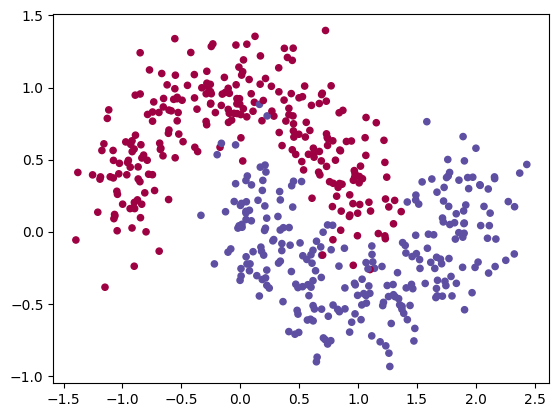

In [15]:
np.random.seed(2019)

# training set
X_train, Y_train = sklearn.datasets.make_moons(n_samples=512, noise=.2)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
# test set
X_test, Y_test = sklearn.datasets.make_moons(n_samples=256, noise=.2)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train.reshape(-1), s=20, cmap=plt.cm.Spectral);

Optimizing the model parameters using mini-batch gradient descent


Loss after 1 epoch: 0.65792
Loss after 1000 epochs: 0.44724
Loss after 2000 epochs: 0.39271
Loss after 3000 epochs: 0.41003
Loss after 4000 epochs: 0.37876
Loss after 5000 epochs: 0.26627
Loss after 6000 epochs: 0.35991
Loss after 7000 epochs: 0.35646
Loss after 8000 epochs: 0.42315
Loss after 9000 epochs: 0.22822
Loss after 10000 epochs: 0.23001
88.1% training acc.
87.1% test acc.


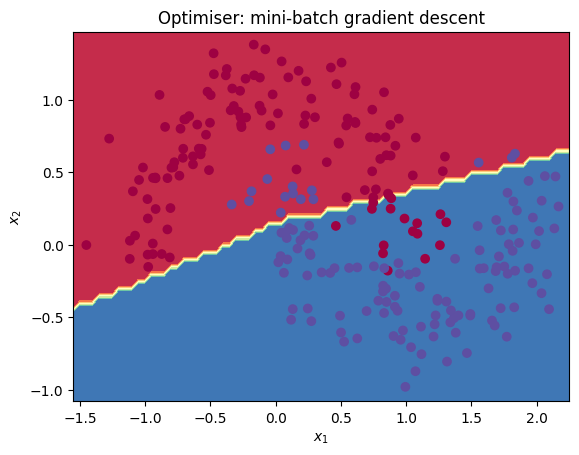

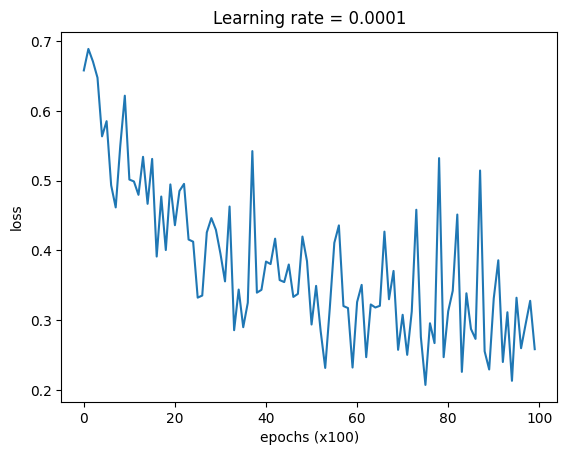

In [16]:
# train feed-forward model using mini-batch gradient descent
optimiser = {'name': 'gradient_descent', 'mini_batch_sz': 32}
lambd = 1e-4
params, grads, loss_log = model_fit(X_train, Y_train, n_h=[8, 3], optimiser=optimiser, epochs=10000, learning_rate=lambd)

# evaluate model
Y_hat_train = t6.model_predict(params, X_train)
Y_hat_test = t6.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t6.plot_model(lambda x: t6.model_predict(params, x), X_test, Y_test.reshape(-1), "Optimiser: mini-batch gradient descent")

# plot loss
plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(lambd))
plt.show()

Optimizing the model parameters using momentum. Gains are negligible with this shallow model but will be more noticeable with larger models. Note the oscillations during training with some mini-batches leading to more stochastic noise.


Loss after 1 epoch: 0.65799
Loss after 1000 epochs: 0.44728
Loss after 2000 epochs: 0.39273
Loss after 3000 epochs: 0.41004
Loss after 4000 epochs: 0.37877
Loss after 5000 epochs: 0.26628
Loss after 6000 epochs: 0.35991
Loss after 7000 epochs: 0.35646
Loss after 8000 epochs: 0.42314
Loss after 9000 epochs: 0.22823
Loss after 10000 epochs: 0.23002
88.1% training acc.
87.1% test acc.


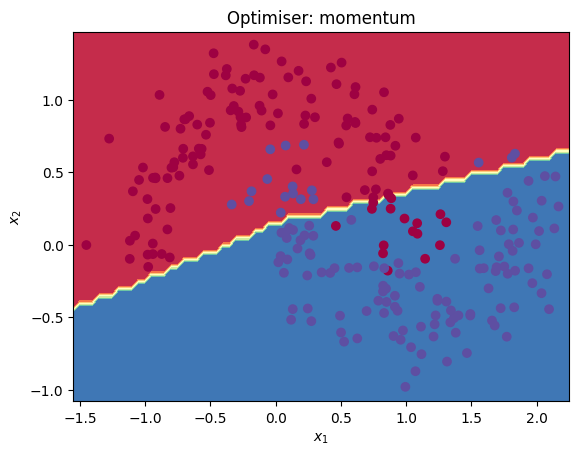

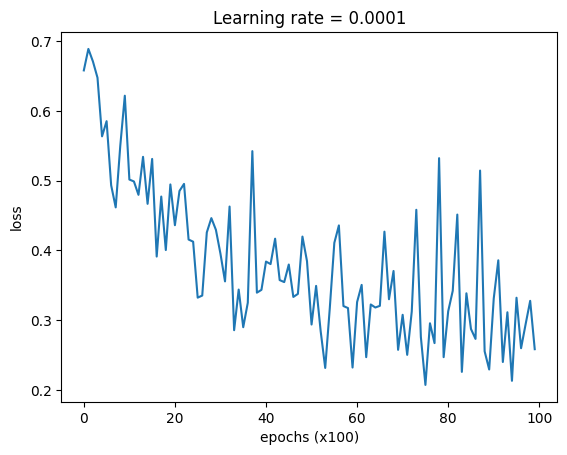

In [17]:
# train feed-forward model using momentum
optimiser = {'name': 'momentum', 'mini_batch_sz': 32, 'beta': 0.9}
lambd = 1e-4
params, grads, loss_log = model_fit(X_train, Y_train, n_h=[8, 3], optimiser=optimiser, epochs=10000, learning_rate=lambd)

# evaluate model
Y_hat_train = t6.model_predict(params, X_train)
Y_hat_test = t6.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t6.plot_model(lambda x: t6.model_predict(params, x), X_test, Y_test.reshape(-1), "Optimiser: momentum")

# plot loss
plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(lambd))
plt.show()

Optimizing the model parameters using Adam. Note the faster convergence of the Adam algorithm. Both gradient descent and momentum will eventually reach similar performance if trained longer.


Loss after 1 epoch: 0.65634
Loss after 1000 epochs: 0.25558
Loss after 2000 epochs: 0.14308
Loss after 3000 epochs: 0.09028
Loss after 4000 epochs: 0.08080
Loss after 5000 epochs: 0.10649
Loss after 6000 epochs: 0.06193
Loss after 7000 epochs: 0.13396
Loss after 8000 epochs: 0.18099
Loss after 9000 epochs: 0.04849
Loss after 10000 epochs: 0.00528
96.7% training acc.
96.5% test acc.


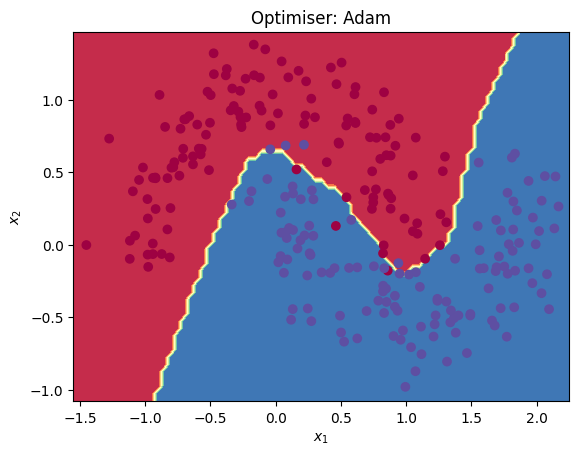

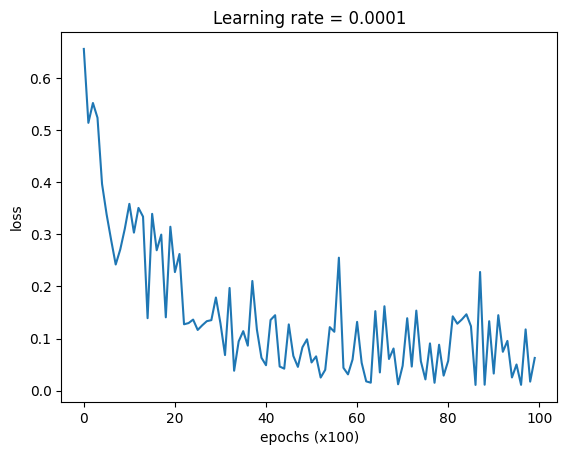

In [18]:
# train feed-forward model using adam
optimiser = {'name': 'adam', 'mini_batch_sz': 32, 'beta1': 0.9, 'beta2': 0.999, 'epsilon':1e-8}
lambd = 1e-4
params, grads, loss_log = model_fit(X_train, Y_train, n_h=[8, 3], optimiser=optimiser, epochs=10000, learning_rate=lambd)

# evaluate model
Y_hat_train = t6.model_predict(params, X_train)
Y_hat_test = t6.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t6.plot_model(lambda x: t6.model_predict(params, x), X_test, Y_test.reshape(-1), "Optimiser: Adam")

# plot loss
plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(lambd))
plt.show()

The Adam optimiser is a popular algorithm for training neural networks. It generally achieves good optimisation with default hyper-parameter values $\beta_1$ and $\beta_2$ and a little tuning of the learning rate $\lambda$. Note the additional memory requirements for training ; in addition to the gradient, two momentum scalars are cached for each trainable model parameter.
